<a href="https://colab.research.google.com/github/FedericoMilanesio/Unito-NeuralNetworks/blob/main/notebooks/Lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

*Tutors*:
-- Federico Milanesio: federico.milanesio@unito.it
-- Davide Pirovano: davide.pirovano@unito.it

<div>
<img src="https://imgs.xkcd.com/comics/compiling.png" width="400"/>
</div>

We already introduced torchvision last lesson, and it contains many things we will use this lesson

In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision                    # <-- here it is

# Using GPUs

GPUs, or **Graphics Processing Units**, are specialized hardware components designed primarily for handling complex graphics and parallel computations. Originally developed for rendering graphics in video games and visual applications, GPUs have evolved to become powerful processors used in a wide range of computational tasks beyond graphics rendering. Luckily, Colab provides **free access to GPUs** that can be used to accelerate computations, particularly in tasks like training deep learning models.

First of all, let's check if there are GPUs available.

If they aren't, then got to `Edit` -> `Notebooks settings` -> `Hardware accelerator` and select `T4 GPU`

In [2]:
torch.cuda.is_available()                           # Are GPU accessible

True

In [3]:
torch.cuda.device_count()                           # How many GPUs do we have?

1

Let's see how to load our data in the GPU:

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)                                        # Check which device we got

cuda:0


In [5]:
a = torch.tensor([0, 30, 50, 75, 70])                # Initialize a Tensor of Integers with no device specified

print(a.is_cuda, "The device used is", a.device)     # Check which device Tensor is created on

False The device used is cpu


In [6]:
a = a.to(device)                                     # we use this to ensure that the operations are done using GPUs

print(a.is_cuda, "The device used is", a.device)

True The device used is cuda:0


Alternatively, we can also write:

In [7]:
a = torch.tensor([0, 30, 50, 75, 70], device = device)

print(a.is_cuda, "The device used is", a.device)

True The device used is cuda:0


Let's test performances with  `%%timeit`, a magic command in notebooks that is used to measure the **execution time** of a single-line Python statement or expression over multiple runs and provide the average time taken per run. It also automatically adjusts the number of runs based on how long the code takes to execute. It runs the code multiple times and adjusts the number of runs to get a reliable estimate of execution time.

For small matrices, CPUs perform better:

In [8]:
%%timeit

n = 5

a = torch.randn((n,n), device = device)
b = torch.randn((n,n), device = device)

torch.matmul(a, b)

34.8 µs ± 906 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit

n = 5

a = torch.randn((n,n))
b = torch.randn((n,n))

torch.matmul(a, b)

12.2 µs ± 3.11 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


But the performance of CPUs worsen with large matrices, while the GPUs remain stable:

In [10]:
%%timeit

n = 100

a = torch.randn((n,n), device = device)
b = torch.randn((n,n), device = device)

torch.matmul(a, b)

35.9 µs ± 467 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%%timeit

n = 100

a = torch.randn((n,n))
b = torch.randn((n,n))

torch.matmul(a, b)

336 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Importing the dataset

In [13]:
batch_size_train = 128
batch_size_test = 500

n_train = 2000
n_test = 500

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

## TRAIN SET

dataset_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=transform)


dataset_train.data, dataset_train.targets = dataset_train.data[:n_train], dataset_train.targets[:n_train]

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train,
                                            shuffle = True,  drop_last = True)                   # <-- drop_last: ignores the last batch if it is smaller than other batches

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15982660.69it/s]


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 480211.27it/s]


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4412440.39it/s]


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5227916.79it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [14]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

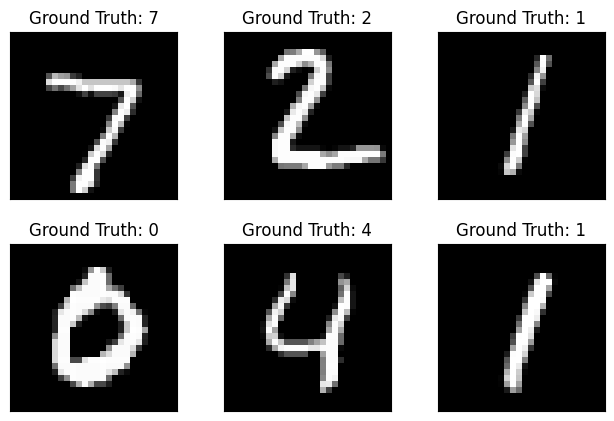

In [15]:
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

In [16]:
input_dim = 28*28
hidden_dim = 10
out_dim = 10

class SimpleNetwork(nn.Module):

  def __init__(self, input_dim, hidden_dim, out_dim):

    # this function is called when creating a new network

    super(SimpleNetwork, self).__init__()

    self.flatten = nn.Flatten(1, 3)
    self.layer_1 = nn.Linear(input_dim, hidden_dim)
    self.activation = nn.ReLU()                                     # this is the activation used in the hidden layer
    self.layer_2 = nn.Linear(hidden_dim, out_dim)
    self.soft = nn.Softmax(dim=1)                                   # this is the activation used before the output

  def forward(self, x):

    # this function is called each new prediction

    x = self.flatten(x)
    x = self.layer_1(x)                                              # this is equivalent to x @ w + b
    x = self.activation(x)                                           # this is equivalent to ReLU(x)

    x = self.layer_2(x)
    x = self.soft(x)

    return x

model = SimpleNetwork(input_dim, hidden_dim, out_dim).to(device)     # we move our model to the GPUs
model = torch.compile(model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [17]:
loss_function = nn.CrossEntropyLoss()

In [18]:
@torch.compile
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = corrects.sum().float()

  return accuracy

@torch.compile
def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

  acc_train, acc_test = 0, 0

  with torch.no_grad():

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

      out = model(x_train).squeeze()
      acc_train += accuracy(out, y_train)

    for x_test, y_test in test_loader:

      x_test, y_test = x_test.to(device), y_test.to(device)

      out = model(x_test).squeeze()
      acc_test += accuracy(out, y_test)

    acc_train, acc_test = acc_train / len(train_loader.dataset), acc_test / len(test_loader.dataset)

  return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100

@torch.compile
def train(model, x, y):
  out = model(x_train)
  loss = loss_function(out.squeeze(), y_train)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()
  return float(loss)


In [19]:
EPOCHS = 100

train_losses = []
train_accuracies = []
test_accuracies = []

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(EPOCHS):

  train_loss = 0

  ## TRAIN STEP

  for x_train, y_train in train_loader:

    x_train, y_train = x_train.to(device), y_train.to(device)


    loss = train(model, x_train, y_train)

    train_loss += loss

  train_loss /= len(train_loader)                    # we divide by the number of batches
  train_losses.append(train_loss)

  ## TEST STEP

  if epoch % 10 == 0:

    train_acc, test_acc = evaluate(model, train_loader, test_loader)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print("Epoch:", epoch, "Loss:", float(train_loss))


Epoch: 0 Loss: 2.2896546999613445
Epoch: 10 Loss: 1.816642435391744
Epoch: 20 Loss: 1.7319644848505655
Epoch: 30 Loss: 1.706404415766398
Epoch: 40 Loss: 1.6945891618728637
Epoch: 50 Loss: 1.6903156201044718
Epoch: 60 Loss: 1.6804586887359618
Epoch: 70 Loss: 1.6809536218643188
Epoch: 80 Loss: 1.6796088059743246
Epoch: 90 Loss: 1.675843850771586


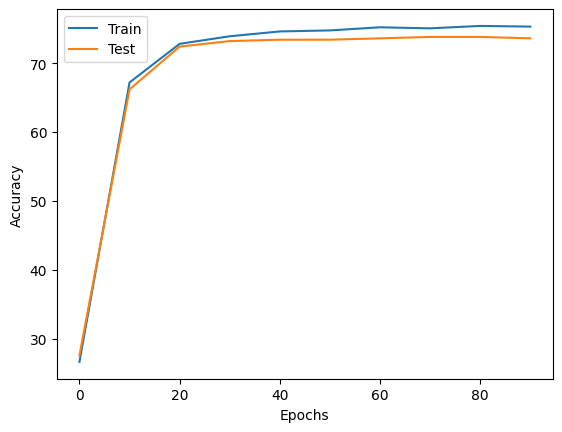

In [20]:
epochs = [i*10 for i in range(EPOCHS//10)]

plt.plot(epochs, train_accuracies, label = "Train")
plt.plot(epochs, test_accuracies, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")


plt.legend()

plt.show()

# Let's get convolutional

We introduce the basic layer for convolutional networks: `torch.nn.Conv2d`.
This layer performs 2D convolution on input tensors. It applies a 2D filter (kernel) to the input tensor and computes the element-wise multiplication followed by summation to produce the output feature map.

Parameters of interest include:

* **in_channels**: Number of input channels.
* **out_channels**: Number of output channels (i.e., number of filters).
* **kernel_size**: Size of the convolutional kernel.
* **stride**: Stride of the convolution.
* **padding**: Padding added to input feature map.

**Exercise 1:** write a network using convolutional layers

In [21]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self, input_dim, out_dim):

    self.input_dimm = input_dim
    self.out_dim = out_dim

  def forward(self, x):

    return x


In [23]:
...

Ellipsis

# Data augmentation

Data augmentation is a technique used to increase the diversity of training data by applying random transformations to the original dataset. This approach helps improve the **generalization and robustness** of deep learning models, especially when the available training dataset is limited or when the model needs to be invariant to certain transformations during inference.


Common Transformations:
* **Random Resizing and Cropping**:

`transforms.RandomResizedCrop`: Randomly crops and resizes the input image to a specified size.
* **Random Horizontal and Vertical Flipping**:

`transforms.RandomHorizontalFlip`: Randomly flips the input image horizontally with a given probability.

`transforms.RandomVerticalFlip`: Randomly flips the input image vertically with a given probability.
* **Random Rotation**:

`transforms.RandomRotation`: Randomly rotates the input image by a specified angle.
* **Color and Brightness Adjustments**:

`transforms.ColorJitter`: Randomly adjusts brightness, contrast, saturation, and hue of the input image.


In [24]:
import torchvision.transforms as transforms

batch_size_train = 128
batch_size_test = 500

n_train = 2000
n_test = 500

# Define data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize( (0.1307,), (0.3081,))
])

transform = torchvision.transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize( (0.1307,), (0.3081,)) ])


## TRAIN SET

dataset_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=train_transform)


dataset_train.data, dataset_train.targets = dataset_train.data[:n_train], dataset_train.targets[:n_train]

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train,
                                            shuffle = True,  drop_last = True)

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)



In [25]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

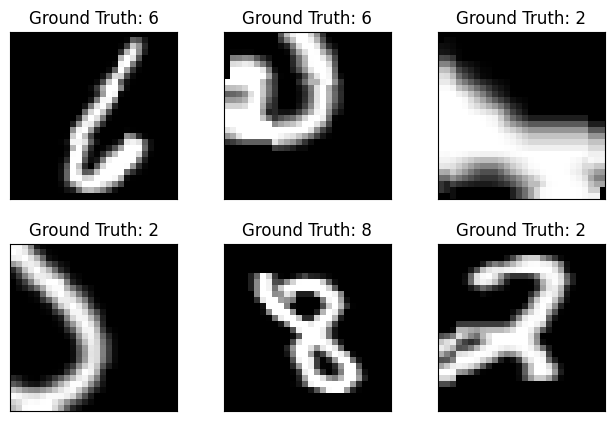

In [26]:
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

**Exercise 2:** Maybe these images are *too* augmented. Try to refine `train_transform` to generate images that still have meanining (and then train the network again and see if the performances improve)


In [ ]:
...

# Other useful layers

Here are some useful layers for convolutional networks.

* **2D max pooling/average pooling**

`torch.nn.MaxPool2d` and `torch.nn.AvgPool2d` downsample the input feature maps by taking either the maximum or average value within a specified window (kernel size) and stride.

*Parameters*: kernel_size, stride, padding, ceil_mode (for MaxPool2d).



* **Batch normalization**

`torch.nn.BatchNorm2d` normalizes the activations of each channel across a mini-batch. It helps in stabilizing and accelerating the training of deep neural networks by reducing internal covariate shift.

*Parameters*: num_features (number of input channels).



* **Dropout**

`torch.nn.Dropout` layer randomly sets a fraction of input units to zero during training, which helps in reducing overfitting by preventing complex co-adaptations of neurons.

*Parameter*: p (probability of dropping a neuron).

**IMPORTANT**: In PyTorch, `model.train()` is a method used to set the model in training mode. This method is typically called on a PyTorch model object before starting the training loop. This mode is important because **certain layers like dropout and batch normalization behave differently during training** compared to evaluation (testing) mode. To switch them you have to call `model.train()` and `model.eval()` before the respective steps. Here an example:

In [ ]:
EPOCHS = 10


for epoch in range(EPOCHS):

  ## TRAIN STEP

  model.train()

  for x_train, y_train in train_loader:

    ...

  ## TEST STEP

  model.eval()

  ...


**Exercise 3:** Now it's up to you! Mix all these ingredients and try to reach a high accuracy on the test set (if it is too easy, use less sample in the training set)


In [ ]:
...

*© 2024. This work is openly licensed via [CC BY-NC-SA 4.0 DEED](https://creativecommons.org/licenses/by-nc-sa/4.0/)*

*Comics used in the notebooks are from [xkcd.com](https://xkcd.com), and are licensed under the Creative Commons Attribution-NonCommercial 2.5 license.*

*Details and usage notes can be found at [xkcd.com/license.html](https://xkcd.com/license.html).*